In [28]:
import cv2
import os
import sys
import numpy as np
import sklearn
from skimage.feature import hog
from sklearn.svm import SVC
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from joblib import dump, load

In [2]:
def read_train_image(fullpath):
    image  = cv2.imread(fullpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

In [3]:
def load_train_images(folder):
    samples = []
    for file in os.listdir(folder):
        filename = os.fsdecode(file)
        if filename.endswith(".png"):
            fullpath = folder + filename
            image = read_train_image(fullpath)
            samples.append(image)
    return samples

In [4]:
def load_digit_train_set(folder, label):
    images = load_train_images(folder)
    labels = np.repeat(label, len(images))
    print(len(labels))
    return list(zip(images, labels))

In [5]:
def load_digits_train_set(folder):
    entire_set = []
    for digit in range(10):
        digits = []
        if digit == 0:
            digits = load_digit_train_set(folder + "none/", 0)
        else:
            digits = load_digit_train_set(folder + f"{digit}/", digit)
        entire_set.extend(digits)
    return entire_set

In [6]:
data = load_digits_train_set("../data/")

4602
256
291
290
328
300
326
324
262
327


In [7]:
X = [x[0] for x in data]
y = [x[1] for x in data]

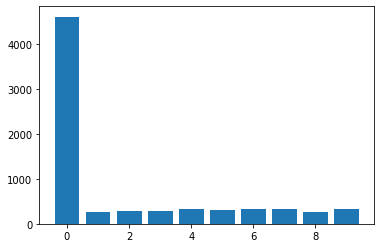

In [10]:
counter = Counter(y)
plt.bar(counter.keys(), counter.values())
plt.show()

In [12]:
from sklearn.utils import resample
majority = [x for x in data if x[1] == 0]
minority = [x for x in data if x[1] > 0]
majority_downsampled = resample(
    majority,
    replace=False,
    n_samples=len(minority) // 8,
    random_state=42)

downsampled = majority_downsampled + minority

In [13]:
X = [x[0] for x in downsampled]
y = [x[1] for x in downsampled]

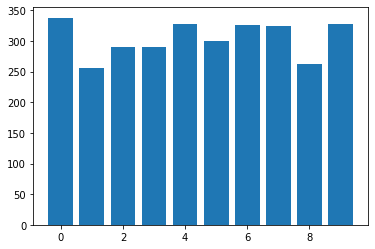

In [14]:
counter = Counter(y)
plt.bar(counter.keys(), counter.values())
plt.show()

In [16]:
def calculate_features_hog(images):
    return np.array([hog(image) for image in images])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [25]:
features_train = calculate_features_hog(X_train)
features_test = calculate_features_hog(X_test)

In [27]:
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [10, 100]}
]

scores = ["precision", "recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(features_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(features_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.995 (+/-0.004) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.980 (+/-0.008) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.996 (+/-0.006) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.995 (+/-0.004) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        77
           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00        60
           3       1.00      1.00      1.00        46
           4       0.99      1.00      0.99        67
           5       1.00      1.00      1.00        54
           6       1.00      1.00      1.00        71
    

In [29]:
classifier = svm.SVC(C=100, kernel='rbf', gamma=0.001)
classes = y_train
classifier.fit(features_train, classes)

SVC(C=100, gamma=0.001)

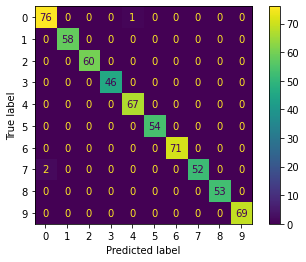

In [30]:
y_pred = classifier.predict(features_test)
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(cm)
disp.plot()

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        77
           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00        60
           3       1.00      1.00      1.00        46
           4       0.99      1.00      0.99        67
           5       1.00      1.00      1.00        54
           6       1.00      1.00      1.00        71
           7       1.00      0.96      0.98        54
           8       1.00      1.00      1.00        53
           9       1.00      1.00      1.00        69

    accuracy                           1.00       609
   macro avg       1.00      0.99      1.00       609
weighted avg       1.00      1.00      1.00       609



In [32]:
dump(clf, '../trained_models/svm.joblib')

['../trained_models/svm.joblib']

In [34]:
clf = load('../trained_models/svm.joblib') 